__Importing the vehicle model__

In [2]:
%run "ev_sub.ipynb"

57.0
126.66666666666667
45
11.739130434782608
1.368
116.53333333333335
156.52173913043475
16.416
104.88000000000002
403.20000000000005
288.0
364.79999999999995
115.19173063162575
0.8315615999999998
1581.5217391304348
1656.5217391304348
555.1020408163266
2211.6237799467613
131.94689145077132


__Importing the cycle data__

In [3]:
cols = ['time','speed']
df = pd.read_csv('us06.txt',delimiter ='\t',header = None, names = cols)
df.drop(index = [0,1], axis = 1, inplace = True)
df.reset_index(drop = True, inplace = True)
df = df.apply(pd.to_numeric)

# Conversion of the speed from mph to m/s
df['speed'] = 1.609344*df['speed']/3.6

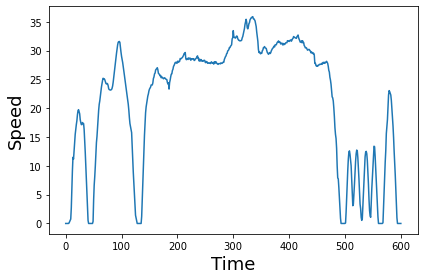

In [4]:
plt.plot(df['time'], df['speed'])

plt.xlabel('Time', size = 18)
plt.ylabel('Speed', size = 18)
plt.tight_layout()
plt.show()

__Defining the road grade__

In [5]:
# max_grade = 10*np.pi/180

# grade = np.arange(0,max_grade,max_grade/len(df))

In [6]:
grade = 0.3

if np.isscalar(grade):
    
    grade = np.tile(np.arctan(grade/100),len(df))
    
else:
    
    grade = np.arctan(grade/100)

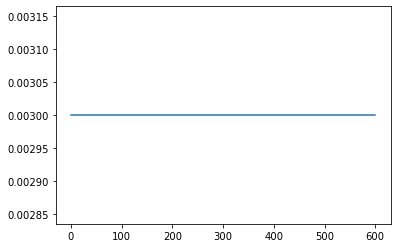

In [7]:
plt.plot(df['time'],grade)
plt.show()

__Calculating the vehicle related parameters__

In [8]:
result = {}

__Defining the variables__

In [9]:
# Vehicle desired speed in m/s
des_speed = np.zeros(len(df))

# Desired acceleration
des_acc = np.zeros(len(df))

# Desired acceleration force
des_acc_force = np.zeros(len(df))

# Aerodynamic force
aero_force = np.zeros(len(df))

# Rolling force on gradient
roll_grade_force = np.zeros(len(df))

# Vehicle torque demand
T_demand = np.zeros(len(df))

# Maximum torque
T_max = np.zeros(len(df))

# Regeneation limit
limit_regen = np.zeros(len(df))

# Limit Torque
T_limit = np.zeros(len(df))

# Motor torque
T_motor = np.zeros(len(df))

# Power demand
P_demand = np.zeros(len(df))

# Limit power
P_limit = np.zeros(len(df))

# Battery demand
demand_battery = np.zeros(len(df))

# Current
current = np.zeros(len(df))

# Battery SOC
bat_SOC = np.zeros(len(df))

# Actual acceleration 
actual_acc = np.zeros(len(df))

# Actual acceleration force
actual_acc_force = np.zeros(len(df))

# Motor speed
speed_motor = np.zeros(len(df))

# Actual speed
actual_speed = np.zeros(len(df))

# Distance
dist = np.zeros(len(df))

__Initializing the variables__

In [10]:
rho = 1.225
des_speed = df['speed']

prevspeed = 0
prevtime = df['time'][0] - 1
prevmotorspeed = 0
prevsoc = p1.soc_full
prevdist = 0

__Calculating the vehicle parameters__

In [11]:
for i in np.arange(1,len(df),1):

#     i = 50


    # Desired acceleration
    des_acc[i] = (des_speed[i] - prevspeed)/(df['time'][i]-prevtime)

    # Desired accelration forcec
    des_acc_force [i] = v1.eq_mass()*des_acc[i]

    # Aerodynamic force
    aero_force[i] = 0.5*rho*v1.cd*v1.farea*(prevspeed**2)

    # Roll Grade force
    roll_grade_force[i] = v1.max_weight()*9.81*np.sin(grade[i])

    # Rolling resistance
    if (np.abs(actual_speed[i-1]) > 0):

        roll_grade_force[i] = roll_grade_force[i] + w1.roll_coef*v1.max_weight()*9.81

    # Torque required to achieve the acceleration
    T_demand[i] = (des_acc_force[i] + aero_force[i] + roll_grade_force[i] \
                   + v1.road_force)*(w1.radius/d1.gear_ratio)

    # Finding the torque provided by the motor for the given speed
    if (prevmotorspeed < m1.rated_RPM):

        T_max[i] = m1.Tmax

    else:

        T_max[i] = m1.Tmax*m1.rated_RPM/prevspeed

    # Limit for regenerating torque
    limit_regen[i] = min(T_max[i],d1.T_regen*m1.Tmax)

    # Actual torque provided by the motor
    T_limit[i] = min(T_demand[i],T_max[i])


    if (T_limit[i] > 0):

        T_motor[i] = T_limit[i]

    else:

        T_motor[i] = max(-limit_regen[i],T_limit[i])


    # Actual acceleration force calculation
    actual_acc_force[i] = (T_limit[i]*d1.gear_ratio/w1.radius) \
                            - aero_force[i] \
                            -roll_grade_force[i]-v1.road_force

    # Actual accelration calculation
    actual_acc[i] = actual_acc_force[i]/v1.eq_mass()

    # Actual motor speed
    speed_motor[i] = min(m1.max_RPM, \
                        d1.gear_ratio*\
                        (prevspeed + actual_acc[i]*(df['time'][i]-prevtime))*\
                        (60/(2*np.pi*w1.radius)))

    # Actual vehicle speed
    actual_speed[i] = (speed_motor[i]*2*np.pi*w1.radius)/(60*d1.gear_ratio)

    # Distance travelled by vehicle
    dist [i] = prevdist + 0.5*(actual_speed[i]+prevspeed)*\
            (df['time'][i]-prevtime)/1000


    # Power demand by the vehicle
    if (T_limit[i]  > 0):

        P_demand[i] = T_limit[i]

    else:

        P_demand[i] = max(T_limit[i], -limit_regen[i])

    P_demand[i] = P_demand[i]*2*np.pi*0.5* \
        (speed_motor[i] + prevmotorspeed)/60000

    # Power limit that can be achieved
    P_limit[i] = max(-m1.max_power(), min(m1.max_power(),P_demand[i]))


    # Battery

    demand_battery[i] = v1.p_overhead/1000

    if (P_limit[i] > 0):

        demand_battery[i] = demand_battery[i] + P_limit[i]/d1.eff()

    else:

        demand_battery[i] = demand_battery[i] + P_limit[i]*d1.eff()


    current[i] = demand_battery[i]*1000/p1.vnom()

    bat_SOC[i] = prevsoc - current[i]*(df['time'][i]-prevtime)/(36*mod.mod_cap())

    prevtime = df['time'][i]
    prevspeed = actual_speed[i]
    prevmotorspeed = speed_motor[i]
    prevsoc = bat_SOC[i]
    prevdist = dist[i]


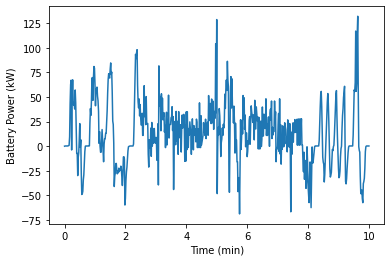

In [12]:
plt.plot(df['time']/60,demand_battery)
plt.xlabel('Time (min)')
plt.ylabel('Battery Power (kW)')
plt.show()

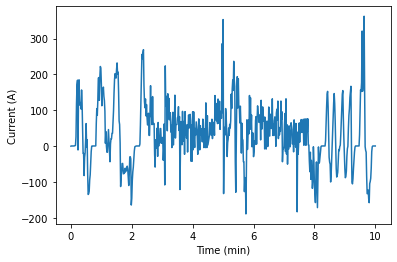

In [13]:
plt.plot(df['time']/60,current)
plt.xlabel('Time (min)')
plt.ylabel('Current (A)')
plt.show()

Text(0, 0.5, 'Torque (N-m)')

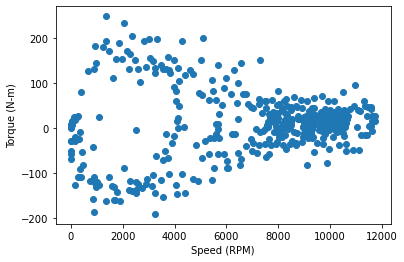

In [14]:
plt.scatter(speed_motor,T_motor)
plt.xlabel('Speed (RPM)')
plt.ylabel('Torque (N-m)')

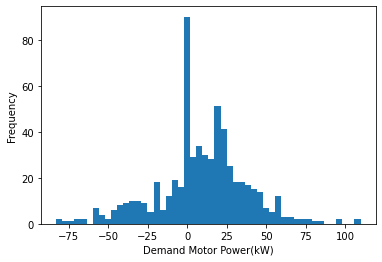

In [15]:
plt.hist(P_demand, bins=50)
plt.xlabel('Demand Motor Power(kW)')
plt.ylabel('Frequency')
plt.show()

<Figure size 432x288 with 0 Axes>

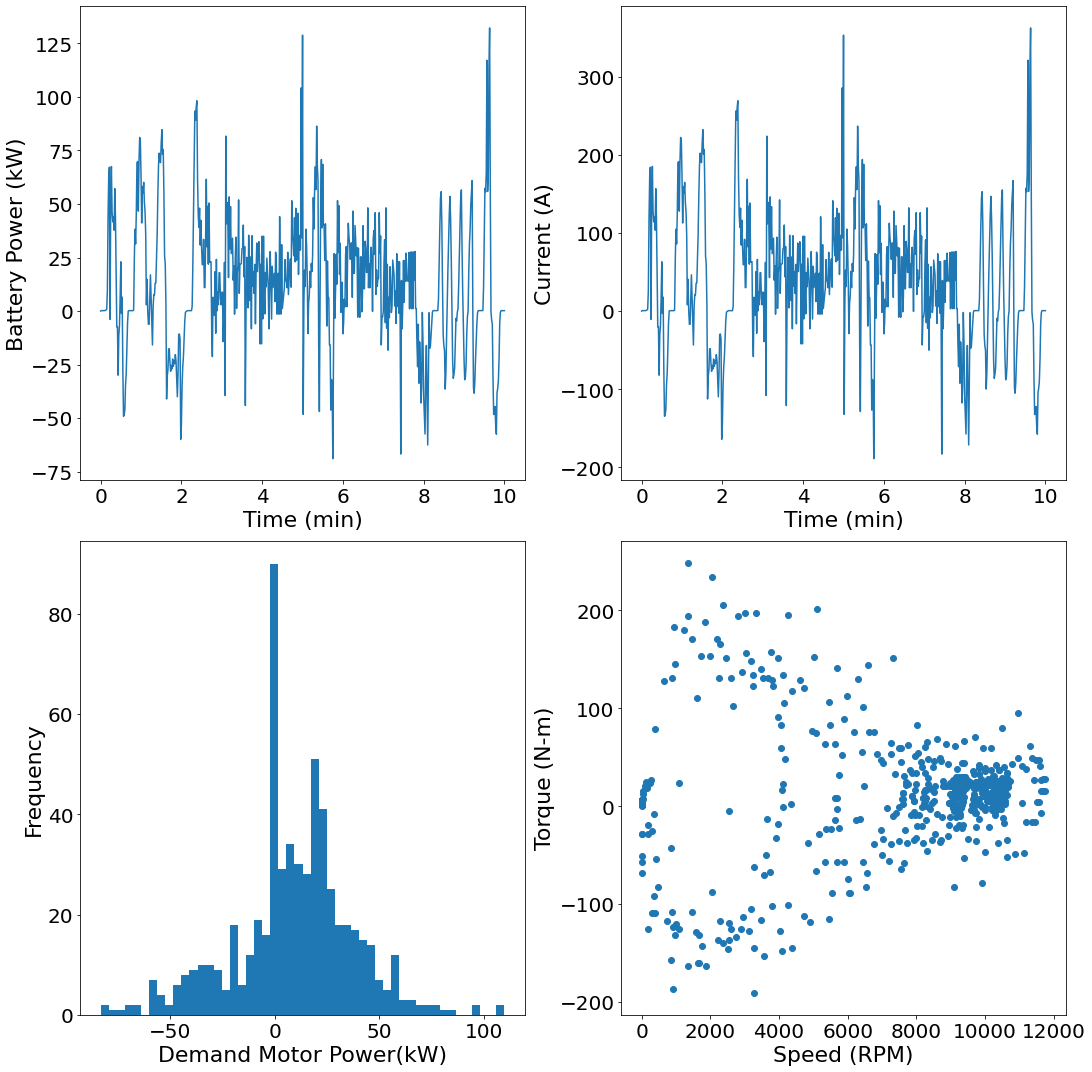

In [19]:
plt.clf()

fig, ax = plt.subplots(2, 2, figsize=(15,15))



ax[0, 0].plot(df['time']/60,demand_battery)
ax[0, 0].set_xlabel('Time (min)',size = 22)
ax[0, 0].set_ylabel('Battery Power (kW)',size = 22)
ax[0,0].tick_params(axis='both', which='major', labelsize=20)

ax[0, 1].plot(df['time']/60,current)
ax[0, 1].set_xlabel('Time (min)',size = 22)
ax[0, 1].set_ylabel('Current (A)',size = 22)
ax[0,1].tick_params(axis='both', which='major', labelsize=20)

ax[1, 0].hist(P_demand, bins=50)
ax[1, 0].set_xlabel('Demand Motor Power(kW)',size = 22)
ax[1, 0].set_ylabel('Frequency',size = 22)
ax[1,0].tick_params(axis='both', which='major', labelsize=20)

ax[1, 1].scatter(speed_motor,T_motor)
ax[1, 1].set_xlabel('Speed (RPM)',size = 22)
ax[1, 1].set_ylabel('Torque (N-m)',size = 22)
ax[1,1].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

plt.show()
